In [97]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

## Load content and style images

In [98]:
def load_img(path, max_dim=512):
    img = Image.open(path)
    long_side = max(img.size)
    scale = max_dim / long_side
    img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

In [99]:
def show_img(img, title=None):
    img = np.squeeze(img, axis=0)
    img = img.astype('uint8')
    plt.title(title)
    plt.axis('off')
    plt.imshow(img)

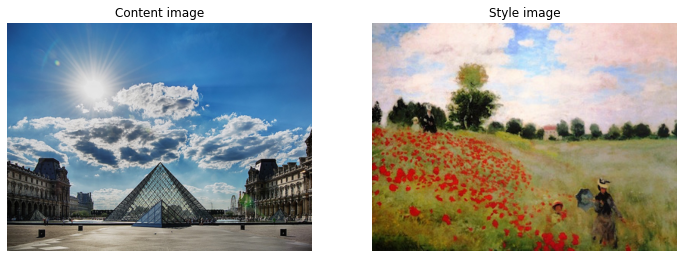

In [100]:
content = load_img('../images/louvre.jpg').astype('uint8')
style = load_img('../images/monet.jpg').astype('uint8')

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
show_img(content, 'Content image')

plt.subplot(1, 2, 2)
show_img(style, 'Style image')

## Define content and style layers

In [101]:
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Load a VGG19 image classification model

In [102]:
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    style_outs = [vgg.get_layer(l).output for l in style_layers]
    content_outs = [vgg.get_layer(l).output for l in content_layers]
    model_outs = style_outs + content_outs
    
    return tf.python.keras.models.Model(vgg.input, model_outs)

## Define a loss function

### Content loss

In [103]:
def get_content_loss(output, content):
    return tf.reduce_mean(tf.square(content - output))

### Style loss

In [104]:
def gram_matrix(input_tensor):
    # Make image channels go first
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [105]:
def get_style_loss(output, style):
    height, width, channels = output.get_shape().as_list()
    gram_style = gram_matrix(output)
    return tf.reduce_mean(tf.square(gram_style - style)) # / (4. * (channels ** 2) * (width * height) ** 2)

## Apply style transfer

In [106]:
def load_and_process_img(path):
    img = load_img(path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [107]:
def get_feature_representations(model, content_path, style_path):
    content_img = load_and_process_img(content_path)
    style_img = load_and_process_img(style_path)
    
    style_outs = model(style_img)
    content_outs = model(content_img)
    
    style_features = [l[0] for l in style_outs[:num_style_layers]]
    content_features = [l[0] for l in content_outs[num_style_layers:]]
    
    return style_features, content_features

In [108]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    
    model_outs = model(init_image)
    
    style_out_features = model_outs[:num_style_layers]
    content_out_features = model_outs[num_style_layers:]
    
    style_loss = 0
    content_loss = 0
    weight_per_style_layer = 1 / num_style_layers
    
    for target_style, comb_style in zip(gram_style_features, style_out_features):
        style_loss += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
        
    weight_per_content_layer = 1 / num_content_layers

    for target_content, comb_content in zip(content_features, content_out_features):
        content_loss += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

    style_loss *= style_weight
    content_loss *= content_weight

    loss = style_loss + content_loss

    return loss, style_loss, content_loss

In [109]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [110]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [111]:
import IPython.display
import time

def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):  
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }

    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 

        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()

            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

In [112]:
content_path = '../images/louvre.jpg'
style_path = '../images/monet.jpg'

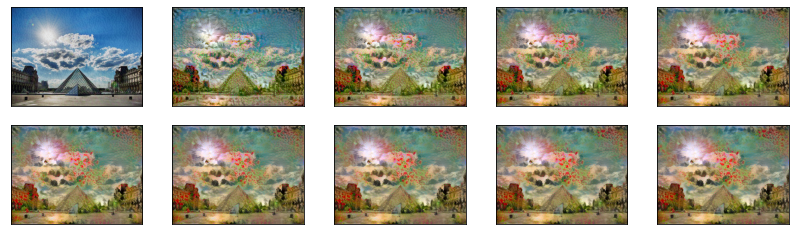

In [113]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)

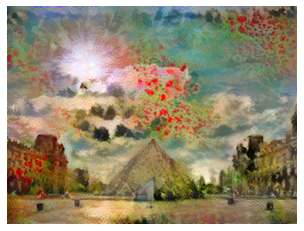

In [121]:
plt.imshow(best)
plt.axis('off')
# plt.figure(figsize=(15,15))
plt.savefig('out.jpg')

In [123]:
import imageio

In [126]:
imageio.imwrite('out.jpg', best)